# Tweets dos possíveis candidatos a presidência em 2022
## Neste estudo queremos determinar qual é a relação entre os possíveis candidatos a presidência para 2022 atraves dos seus tweets publicados. Vamos fazer uma análise destes tweets e treinar um modelo que irá predizer a qual candidato determinado texto pertence.

# Bibliotecas Utilizadas e inicialização

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import spacy
import squarify
import regex as re
import warnings

from collections import Counter
from wordcloud import WordCloud
from datetime import datetime, time

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

nlp = spacy.load("pt_core_news_md")
warnings.filterwarnings('ignore')

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# stopwords e simbolos a retirar
stop_words_portugues = set(stopwords.words('portuguese'))
stop_words_ingles = set(stopwords.words('english'))
stop_words_espanhol = set(stopwords.words('spanish'))
symbols = set(['-', 'r$', 'R$', '|', ' ', 'ser', 'vai', 'pra', 'q', 'p', 'tb', 'vou', 'ter', 'co'])   

# Funções Auxiliares

In [3]:
# Function to remove emoji.
def emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [4]:
def print_topic_words(model, feature_names, n_top_words, topics):
    for index, topic in enumerate(model.components_):
        if (index in topics):
            message = "\nTópico #{}:".format(index)
            message += ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
            print(message)
            print("="*70)

In [5]:
def topico_politico(df, topicos):
    for i in topicos:
        print("\nTópico #{}:".format(i))
        print(df[df["Topico"]==i].groupby(["nome"]).size().sort_values(ascending=False)[:5])

In [6]:
def tweet_tokenizer(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    symbol = set(['-', 'r$', 'R$', '|', ' ', 'co'])

    tweet = text.lower()
    tweet_token = [w for w in tokenize(tweet) if not w in (stop_words_portugues | stop_words_espanhol | stop_words_ingles | symbol)]
    tweet_token = [w for w in tweet_token if re.match(r'http*', w) == None]
    tweet_token = [w for w in tweet_token if emoji_pattern.match(w) == None]
    tweet_token = [w for w in tweet_token if not (w.startswith('@') | w.startswith('#') | w.startswith('\r'))]
    tweet_token = [w for w in tweet_token if w != 'rt']
        
    return " ".join(tweet_token)

In [7]:
def tokenize(texto):
    doc = nlp.tokenizer(texto)
    return [token.lower_ for token in doc if not (token.is_punct | token.is_stop)]

In [8]:
def unnest_tokens(df, # Data Frame (em linhas)
                  coluna_tokenize, # nome da coluna com os textos (tweets)
                  coluna_token_nome='palavra', # nome da coluna com os tokens
                  tokenizer_function=tokenize): # what tokenizer to use
    
    return (df[coluna_tokenize]
              .apply(tokenizer_function)
              .apply(pd.Series)
              .stack()
              .reset_index(level=0)
              .set_index('level_0')
              .rename(columns={0: coluna_token_nome})
              .join(df.drop(coluna_tokenize, 1), how='left')
              .reset_index(drop=True))

In [9]:
def retirando_palavras_indesejadas(df, coluna_token="palavra"):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    df = df[~ df[coluna_token].isin(stop_words_ingles | stop_words_espanhol | symbols)]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if re.match(r'http*', w) != None)]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if emoji_pattern.match(w) != None)]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if (w.startswith('@') | w.startswith('#') | w.startswith('\r') | w.startswith('.')))]
    df = df[~ df[coluna_token].isin(w for w in df[coluna_token] if w == 'rt')]
    return df

In [10]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

In [11]:
def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Carregando os dados 

Os dados foram conseguidos via a API.V2 do tweeter diretamente do Banco de Dados do tweeter. Utilizamos a versão 2 desta API que permite um máximo de 3200 tweets por conta. Portanto a nossa análise vai estar limitada a este número máximo de mensagens o que em alguns casos cobre todos os tweets do político e em outras apenas o último ano.

Utilizamos esta API através do site WORKBENCH - https://app.workbenchdata.com/workflows/142512/

In [12]:
# Dataframe com todos os politicos e seus tweets
lista_dir = os.listdir("./politicos/")
nome_politicos = []
df_politicos = pd.DataFrame()
for nome in lista_dir:
    df_politico = pd.read_csv(
        f"./politicos/{nome}",
        delimiter=",",
        encoding='utf-8',
        usecols=[1,2,8]
    )
    df_politico['nome'] = nome[:-4]
    nome_politicos.append(nome[:-4])
    df_politicos = df_politicos.append(df_politico)
cols = ['nome'] + [col for col in df_politicos if col != 'nome']
df_politicos = df_politicos[cols]
df_politicos.reset_index(inplace=True)

In [13]:
df_politicos.head(10)

index    nome            created_at  \
0      0  Amoedo  2021-04-19T16:18:20Z   
1      1  Amoedo  2021-04-19T16:05:53Z   
2      2  Amoedo  2021-04-19T15:32:40Z   
3      3  Amoedo  2021-04-19T12:53:14Z   
4      4  Amoedo  2021-04-19T12:25:58Z   
5      5  Amoedo  2021-04-19T12:19:42Z   
6      6  Amoedo  2021-04-18T19:21:07Z   
7      7  Amoedo  2021-04-18T19:21:06Z   
8      8  Amoedo  2021-04-18T15:42:35Z   
9      9  Amoedo  2021-04-18T15:42:25Z   

                                                text                   id  
0  RT @MBLivre: Presidente americano Joe Biden an...  1384179569712713735  
1  Temos que fazer a nossa parte. Não podemos dei...  1384176435552608259  
2  O governo federal e o Congresso ignoraram no O...  1384168077697314825  
3  RT @o_antagonista: .@joaoamoedonovo sugeriu no...  1384127951311040517  
4                     Informações de @OGloboPolitica  1384121090243383296  
5  A CPI da Pandemia no Senado deve investigar o ...  1384119514418216969  
6  Leia a coluna completa em https://t.co/rvNDUpnqgA  1383863178853969921  
7  "Membros do Executivo e do Legislativo não ace...  1383863176891015168  
8                       Informações de @RevistaEpoca  1383808183223734272  
9  O governo federal gastará R$500 mil em uma cam...  1383808141897342986

In [14]:
df_politicos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31633 entries, 0 to 31632
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       31633 non-null  int64 
 1   nome        31633 non-null  object
 2   created_at  31633 non-null  object
 3   text        31633 non-null  object
 4   id          31633 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.2+ MB


# 

# Gerando o DataFrame TinyText apenas com as palavras relevantes

In [15]:
# criando dataframe apenas com as palavras e os politicos e o índice original para o tweet.
# já estamos retirando pontuações e STOP WORDS da lingua portuguesa.
#df_palavras = unnest_tokens(df_politicos.drop(['index','created_at','id'], axis=1), 'text')
df_palavras = unnest_tokens(df_politicos.drop(['created_at','id'], axis=1), 'text')

In [16]:
df_palavras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512565 entries, 0 to 512564
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   palavra  512565 non-null  object
 1   index    512565 non-null  int64 
 2   nome     512565 non-null  object
dtypes: int64(1), object(2)
memory usage: 11.7+ MB


In [17]:
df_palavras = retirando_palavras_indesejadas(df_palavras)

In [18]:
df_palavras.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428773 entries, 2 to 512564
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   palavra  428773 non-null  object
 1   index    428773 non-null  int64 
 2   nome     428773 non-null  object
dtypes: int64(1), object(2)
memory usage: 13.1+ MB


In [19]:
df_palavras.head(10)

palavra  index    nome
2   presidente      0  Amoedo
3    americano      0  Amoedo
4          joe      0  Amoedo
5        biden      0  Amoedo
6      anuncia      0  Amoedo
7         hoje      0  Amoedo
8       vacina      0  Amoedo
9   disponível      0  Amoedo
10  americanos      0  Amoedo
12     podemos      1  Amoedo

# Análise inicial das palavras

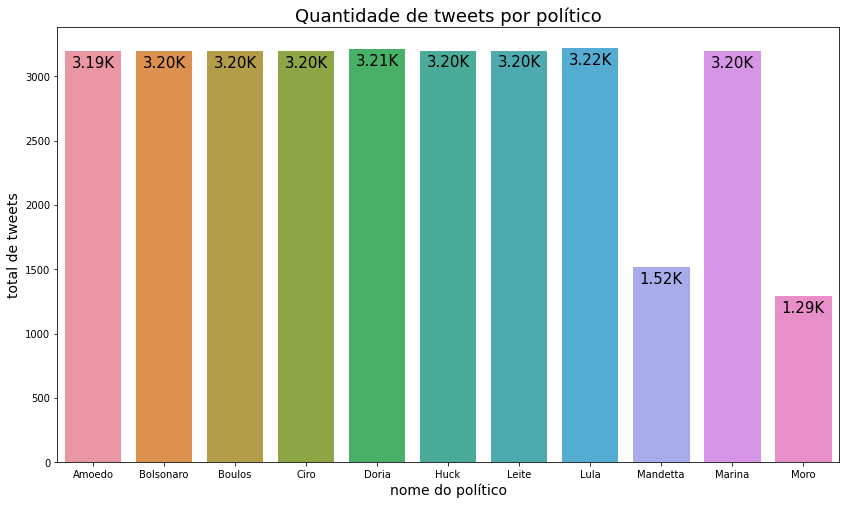

In [20]:
#quantidade de tweets por político

df_plot = df_politicos.groupby('nome').agg(total =('text','count'))
df_plot.reset_index(inplace=True)

plt.figure(figsize=(14, 8))
splot=sns.barplot(x="nome", y="total", data=df_plot)
plt.xlabel("nome do político", size=14)
plt.ylabel("total de tweets", size=14)
plt.title("Quantidade de tweets por político", size=18)
for p in splot.patches:
    splot.annotate(format((p.get_height()/1000), '.2f')+"K", 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  size=15,
                  xytext = (0, -12), 
                  textcoords = 'offset points')

### Conforme informamos no começo da análise o número de tweets está limitado em 3200. Verificamos que os candidatos Mandetta e Moro não possuem este número minimo. Buscando nas datas vemos que os dois, mesmo possuindo conta a menos tempo que os outros, publicam menos em um mesmo período.

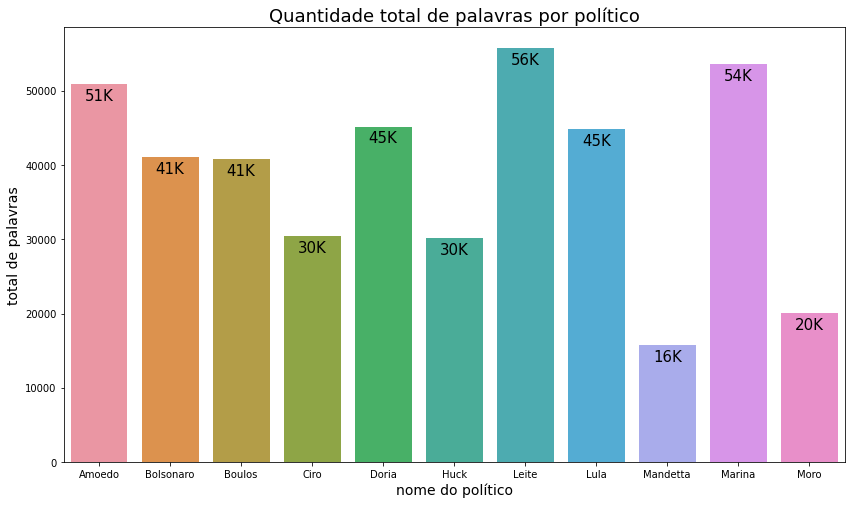

In [21]:
# quantidade de palavras por político

df_plot = df_palavras.groupby('nome').agg(total =('palavra','count'))
df_plot.reset_index(inplace=True)

plt.figure(figsize=(14, 8))
splot=sns.barplot(x="nome", y="total", data=df_plot)
plt.xlabel("nome do político", size=14)
plt.ylabel("total de palavras", size=14)
plt.title("Quantidade total de palavras por político", size=18)
for p in splot.patches:
    splot.annotate(format(round(p.get_height()/1000), '.0f')+"K", 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  size=15,
                  xytext = (0, -12), 
                  textcoords = 'offset points')

### Notamos que os possíveis candidatos Mandetta a Moro possuem menos palavras por terem menos tweets. Mas mesmo entre os com número igual de tweets percebemo que Ciro e Huck devem usar mais palavras de ligação (Stop Words) ou compratilhar links, pois seus números são bem menores que os demais.

# Wordclouds

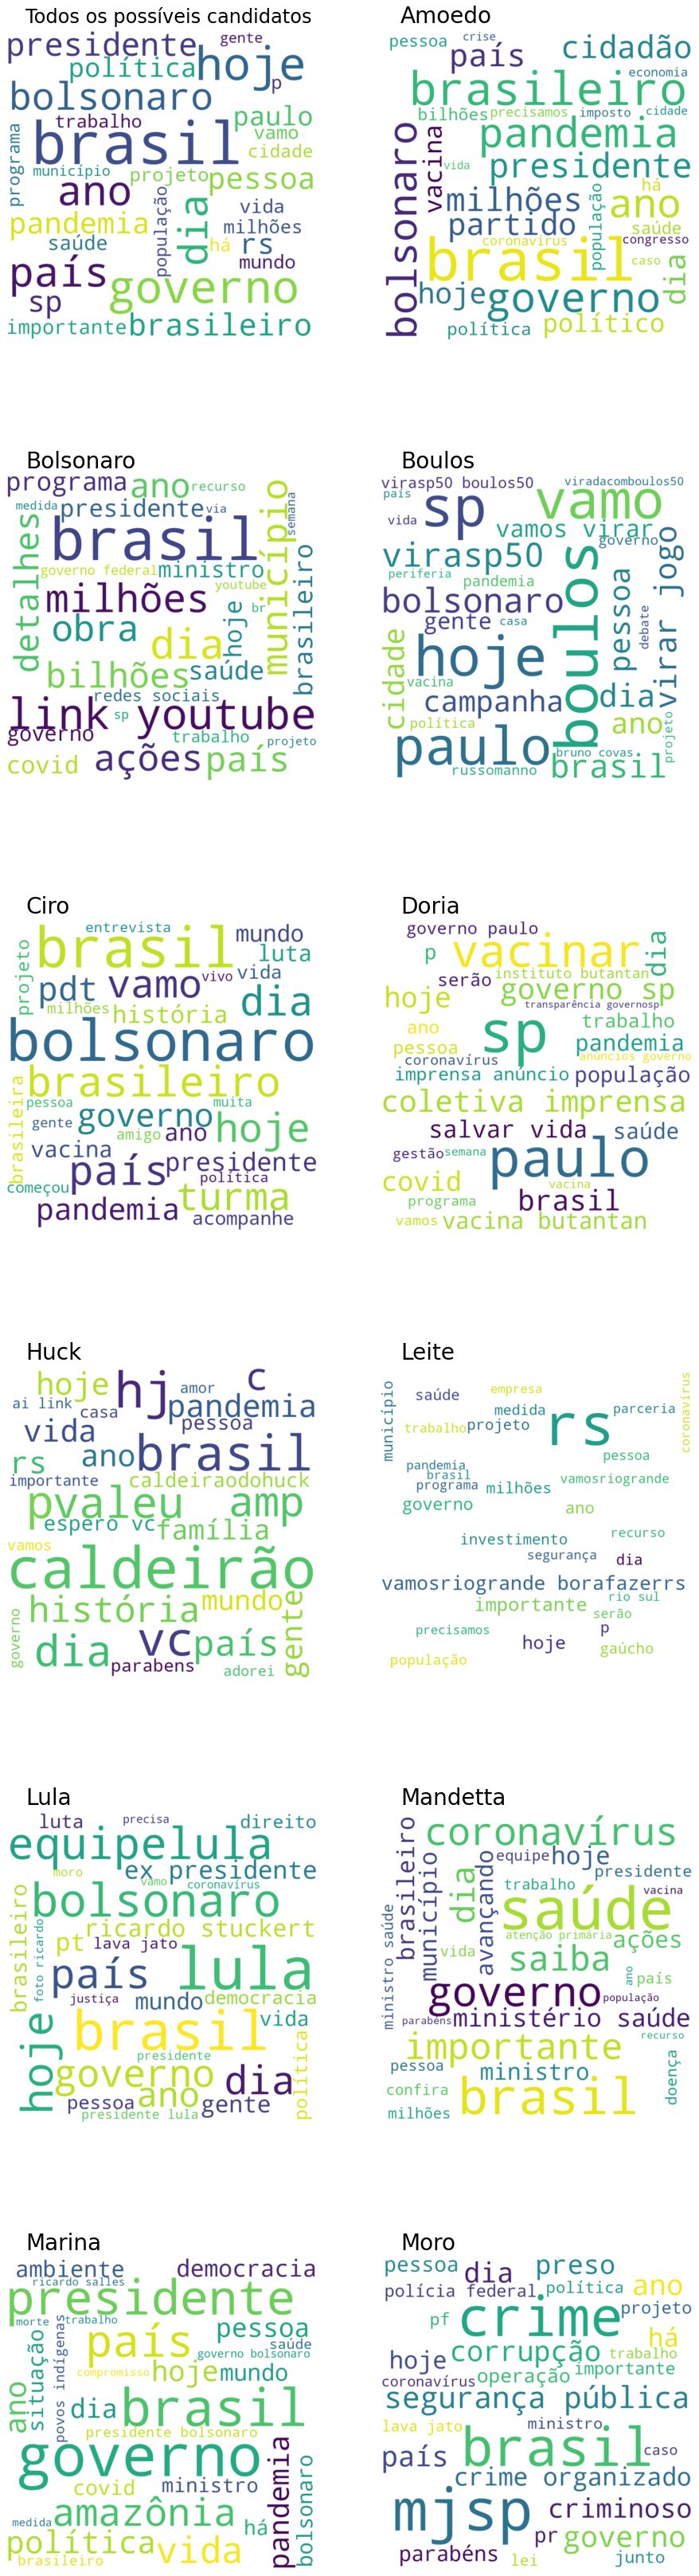

In [22]:
# wordcloud por político
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20, 60), facecolor='w')
xc = 0
yc = 1
sumario = " ".join(s for s in df_palavras['palavra'])
wordcloud = WordCloud(width=800, height=800, max_words=30, max_font_size=150, background_color='white').generate(sumario)
ax[0][0].imshow(wordcloud, interpolation="bilinear")
ax[0][0].text(50, -20, 'Todos os possíveis candidatos', fontsize=24, color='k')
ax[0][0].axis('off')

for idx in range(11):
    sumario = " ".join(s for s in df_palavras['palavra'][df_palavras['nome'] == nome_politicos[idx]])
    wordcloud = WordCloud(width=800, height=800, max_words=30, max_font_size=150, 
            background_color='white').generate(sumario)      
    ax[xc][yc].imshow(wordcloud, interpolation="bilinear")
    ax[xc][yc].text(50, -20, nome_politicos[idx], fontsize=28, color='black')
    ax[xc][yc].axis('off')
    yc += 1
    if (yc == 2):
        yc = 0
        xc += 1
        if (xc == 6):
            xc = 0

plt.subplots_adjust(right=0.8, left=0.2, wspace=0.2, hspace=0.2) 
plt.show()

### Temos uma grande variadade de palavras utilizadas por nosso possíveis candidatos. Apenas o Brasil e Bolsonaro se destacam em quase todos.

# Análise de frequências

In [23]:
# montando dataframe de frequências

c = Counter(df_palavras['palavra']).most_common()
df_palavras_qtd = pd.DataFrame(c, columns=['palavra', 'qtd'])
for politico in nome_politicos:
    c = Counter(df_palavras['palavra'][df_palavras['nome'] == politico]).most_common()
    d = pd.DataFrame(c, columns=['palavra', politico])
    #d[f'f-{politico}'] = d[politico] / df_palavras_qtd['qtd']
    df_palavras_qtd = pd.merge(df_palavras_qtd, d, on='palavra')

In [24]:
#df_palavras_qtd[df_palavras_qtd['palavra'] == " "]
df_palavras_qtd[:20]

palavra   qtd  Amoedo  Bolsonaro  Boulos  Ciro  Doria  Huck  Leite  \
0        brasil  3492     529        406     211   461    248   226    100   
1       governo  2907     292        240     160   213    470    35    284   
2          hoje  2275     142        116     284   237    319   125    423   
3         saúde  2040     212        152     121   149    337    88    227   
4     bolsonaro  2032     276         77     285   618     39     1      6   
5           dia  1696      87        150     172   194    221   222    141   
6          país  1616     226        137      91   190     70   113     54   
7       milhões  1597     221        279      97   108    278    26    303   
8    presidente  1593     233        167      44    97     68    21     83   
9            sp  1447      33         88     371    11    857    20     17   
10     pandemia  1429     235         54     146   103    284   106    165   
11        vamos  1401     114         20     467   306    130    65    105   
12        paulo  1304      51         46     366    56    577    27     38   
13         anos  1211     150         90     146    74    119    88    142   
14      pessoas  1197     119         85     180    52    139    72    147   
15  coronavírus  1165     172         46      13    24    309    12    199   
16         vida  1148      98         49      81    79    212    99    103   
17    população   945     120         59      61    25    286    21    182   
18           rs   933       4         62      11     7      2   103    731   
19       vacina   879     121         51      82    57    397    32     22   

    Lula  Mandetta  Marina  Moro  
0    483       197     488   143  
1    215       153     715   130  
2    290        70     208    61  
3    104       445     186    19  
4    361        17     340    12  
5    201        90     156    62  
6    246        55     346    88  
7     98        52     116    19  
8    264        55     524    37  
9     22         5      14     9  
10    78        25     214    19  
11    92        31      40    31  
12    76        10      39    18  
13   212        29     114    47  
14   126        40     178    59  
15   103       141      87    59  
16   134        41     238    14  
17    35        57      78    21  
18     2         1       2     8  
19    59        22      30     6

In [25]:
df_palavras_freq = df_palavras_qtd.copy()
for politico in nome_politicos:
     df_palavras_freq[politico] =  df_palavras_qtd[politico]/df_palavras_qtd['qtd']

df_palavras_freq[:20]

palavra   qtd    Amoedo  Bolsonaro    Boulos      Ciro     Doria  \
0        brasil  3492  0.151489   0.116266  0.060424  0.132016  0.071019   
1       governo  2907  0.100447   0.082559  0.055040  0.073271  0.161679   
2          hoje  2275  0.062418   0.050989  0.124835  0.104176  0.140220   
3         saúde  2040  0.103922   0.074510  0.059314  0.073039  0.165196   
4     bolsonaro  2032  0.135827   0.037894  0.140256  0.304134  0.019193   
5           dia  1696  0.051297   0.088443  0.101415  0.114387  0.130307   
6          país  1616  0.139851   0.084777  0.056312  0.117574  0.043317   
7       milhões  1597  0.138384   0.174703  0.060739  0.067627  0.174076   
8    presidente  1593  0.146265   0.104834  0.027621  0.060891  0.042687   
9            sp  1447  0.022806   0.060815  0.256393  0.007602  0.592260   
10     pandemia  1429  0.164451   0.037789  0.102169  0.072078  0.198740   
11        vamos  1401  0.081370   0.014276  0.333333  0.218415  0.092791   
12        paulo  1304  0.039110   0.035276  0.280675  0.042945  0.442485   
13         anos  1211  0.123865   0.074319  0.120562  0.061107  0.098266   
14      pessoas  1197  0.099415   0.071011  0.150376  0.043442  0.116124   
15  coronavírus  1165  0.147639   0.039485  0.011159  0.020601  0.265236   
16         vida  1148  0.085366   0.042683  0.070557  0.068815  0.184669   
17    população   945  0.126984   0.062434  0.064550  0.026455  0.302646   
18           rs   933  0.004287   0.066452  0.011790  0.007503  0.002144   
19       vacina   879  0.137656   0.058020  0.093288  0.064846  0.451650   

        Huck     Leite      Lula  Mandetta    Marina      Moro  
0   0.064719  0.028637  0.138316  0.056415  0.139748  0.040951  
1   0.012040  0.097695  0.073959  0.052632  0.245958  0.044720  
2   0.054945  0.185934  0.127473  0.030769  0.091429  0.026813  
3   0.043137  0.111275  0.050980  0.218137  0.091176  0.009314  
4   0.000492  0.002953  0.177657  0.008366  0.167323  0.005906  
5   0.130896  0.083137  0.118514  0.053066  0.091981  0.036557  
6   0.069926  0.033416  0.152228  0.034035  0.214109  0.054455  
7   0.016281  0.189731  0.061365  0.032561  0.072636  0.011897  
8   0.013183  0.052103  0.165725  0.034526  0.328939  0.023227  
9   0.013822  0.011748  0.015204  0.003455  0.009675  0.006220  
10  0.074178  0.115465  0.054584  0.017495  0.149755  0.013296  
11  0.046395  0.074946  0.065667  0.022127  0.028551  0.022127  
12  0.020706  0.029141  0.058282  0.007669  0.029908  0.013804  
13  0.072667  0.117258  0.175062  0.023947  0.094137  0.038811  
14  0.060150  0.122807  0.105263  0.033417  0.148705  0.049290  
15  0.010300  0.170815  0.088412  0.121030  0.074678  0.050644  
16  0.086237  0.089721  0.116725  0.035714  0.207317  0.012195  
17  0.022222  0.192593  0.037037  0.060317  0.082540  0.022222  
18  0.110397  0.783494  0.002144  0.001072  0.002144  0.008574  
19  0.036405  0.025028  0.067122  0.025028  0.034130  0.006826

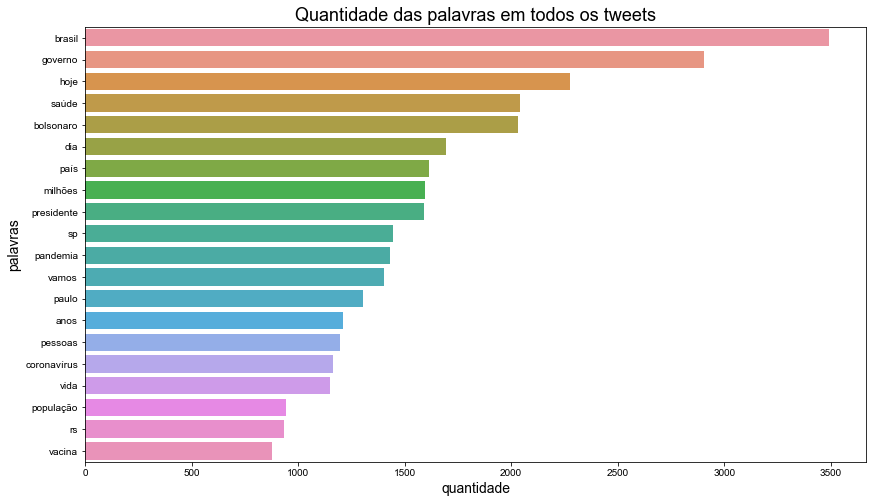

In [26]:
# quantidade de palavras
df_plot = df_palavras_freq[:20]

plt.figure(figsize=(14, 8))
splot=sns.barplot(x="qtd", y="palavra", data=df_plot)
sns.set_style("darkgrid")
plt.xlabel("quantidade", size=14)
plt.ylabel("palavras", size=14)
plt.title("Quantidade das palavras em todos os tweets", size=18)

plt.show()

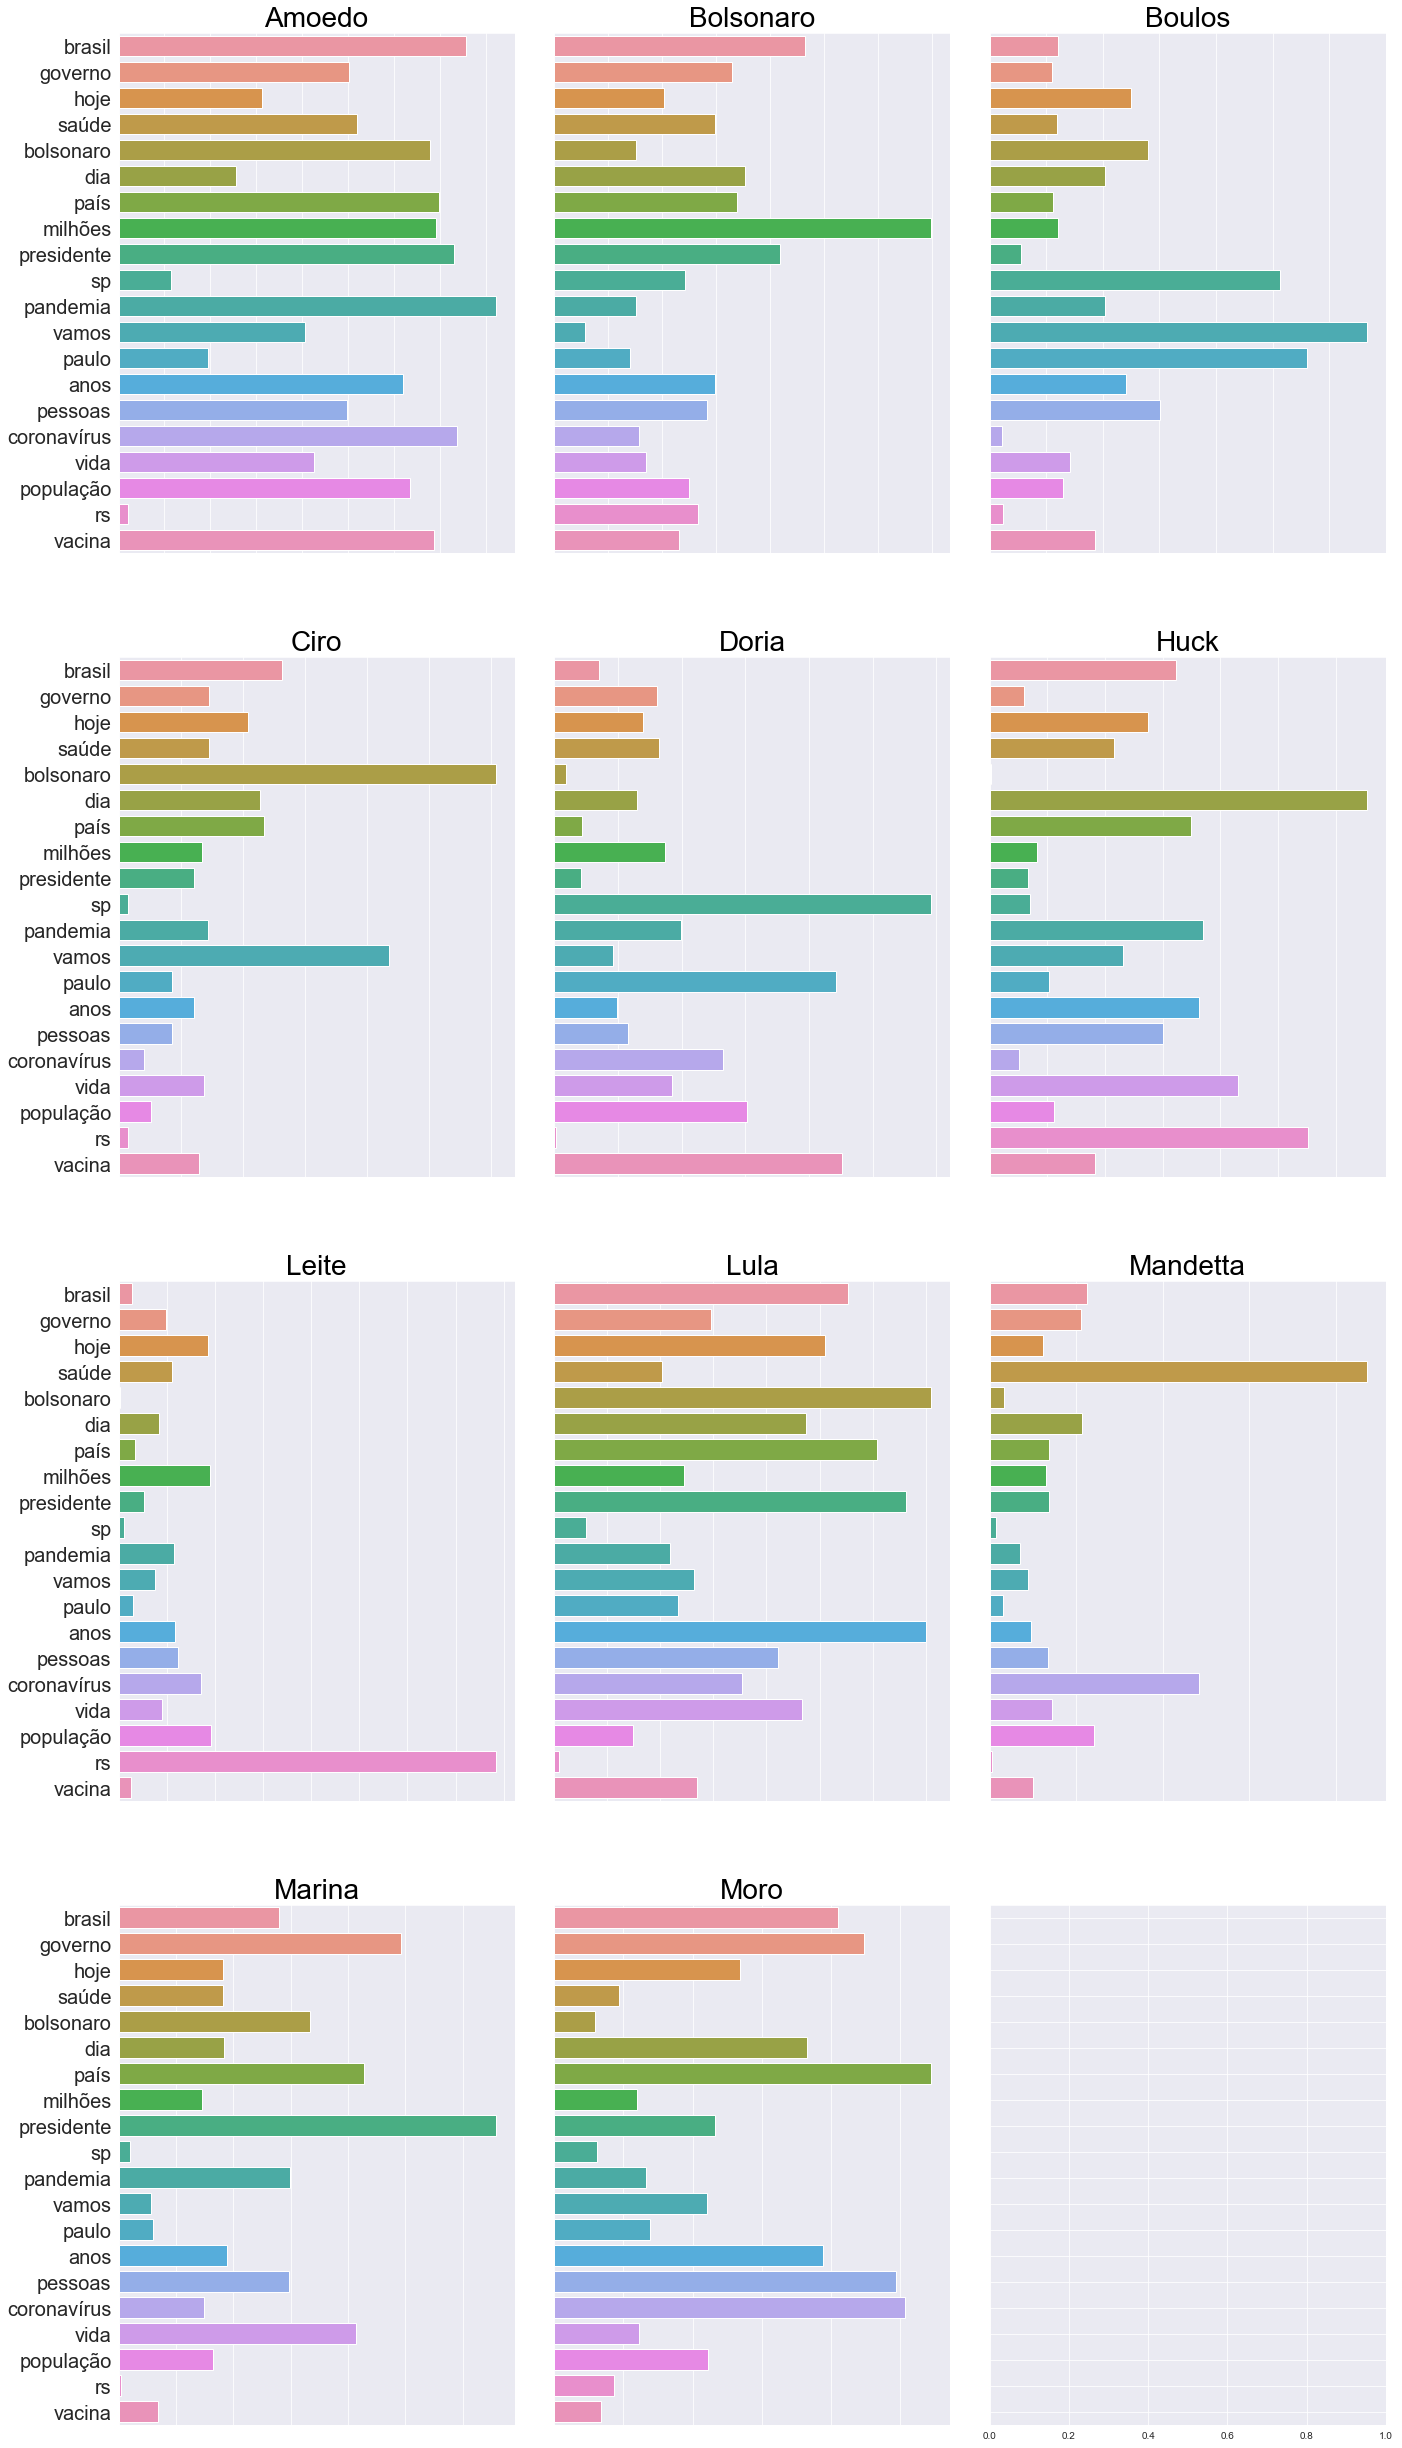

In [27]:
colors = [f'C{x}' for x in range(11)]
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(22, 44), facecolor='w', sharey=True)
xc=0
yc=0
for idx in range(11):
    sns.barplot(y=df_plot['palavra'], x=df_plot[nome_politicos[idx]], ax=ax[xc][yc])
    #ax[xc][yc].barh(y=df_plot['palavra'], width=df_plot[nome_politicos[idx]], height=0.5, color=colors)
    ax[xc][yc].set_title(nome_politicos[idx], fontsize=28, color='black')
    ax[xc][yc].set_ylabel('')
    ax[xc][yc].set_xlabel('')
    ax[xc][yc].tick_params(axis='y', labelsize=20)
    ax[xc][yc].tick_params(axis='x', labelcolor='white')
    yc += 1
    if (yc == 3):
        yc = 0
        xc += 1
        if (xc == 6):
            xc = 0

plt.subplots_adjust(right=0.9, left=0.1, wspace=0.1)
plt.show()

## LDA - Latent Dirichlet Allocation - Modelagem de Tópicos

Alocação Latente de Dirichlet é um modelo estatístico generativo que permite que conjuntos de observações sejam explicados por grupos não observados que explicam o porquê algumas partes dos dados são semelhantes.

In [28]:
# Tokenizando cada tweet dos candidatos
df_politicos['tweet_token'] = df_politicos['text'].apply(tweet_tokenizer)
df_politicos.head()

index    nome            created_at  \
0      0  Amoedo  2021-04-19T16:18:20Z   
1      1  Amoedo  2021-04-19T16:05:53Z   
2      2  Amoedo  2021-04-19T15:32:40Z   
3      3  Amoedo  2021-04-19T12:53:14Z   
4      4  Amoedo  2021-04-19T12:25:58Z   

                                                text                   id  \
0  RT @MBLivre: Presidente americano Joe Biden an...  1384179569712713735   
1  Temos que fazer a nossa parte. Não podemos dei...  1384176435552608259   
2  O governo federal e o Congresso ignoraram no O...  1384168077697314825   
3  RT @o_antagonista: .@joaoamoedonovo sugeriu no...  1384127951311040517   
4                     Informações de @OGloboPolitica  1384121090243383296   

                                         tweet_token  
0  presidente americano joe biden anuncia hoje va...  
1       podemos deixar brasil continuar andando trás  
2  governo federal congresso ignoraram orçamento ...  
3  .@joaoamoedonovo sugeriu twitter temas serem i...  
4                                        informações

In [29]:
tf_vectorizer = CountVectorizer()
tf = tf_vectorizer.fit_transform(list(df_politicos['tweet_token']))

## Grid Search (Hyper Parameter Tunning)

Hyper Parameter Tunning, realizamos Grid Search para encontrar o melhor modelo de LDA, configuramos os hiperparâmetros 'n_components' e 'learning_decay'

In [30]:
# Define Search Param
#search_params = {'n_components':[10, 20, 30, 40, 50], 'learning_decay': [.5, .7, .9]}

# Init the Model
#lda = LatentDirichletAllocation()

# Init Grid Search Class
#model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
#model.fit(tf)

In [31]:
# Melhor modelo
#lda = model.best_estimator_

# Hiperparâmetros do modelo
#print("Melhores parâmetros: ", model.best_params_)

# probabilidade logarítmica
#print("Melhor score de probabilidade logarítmica: ", model.best_score_)

# Perplexidade
#print("Perplexidade do modelo: ", lda.perplexity(tf))

In [32]:
#results = pd.DataFrame(model.cv_results_)

#current_palette = sns.color_palette("Set2", 5)
#plt.figure(figsize=(12,8))
#sns.lineplot(data=results,
#             x='param_n_components',
#             y='mean_test_score',
#             hue='param_learning_decay',
#             palette=current_palette,
#             marker='o'
#            )

#plt.show()

## Treinando Modelo LDA

In [33]:
#Criando o Modelo e treinando
lda = LatentDirichletAllocation(n_components=22,
                                learning_decay = 0.5,
                                random_state = 30)
lda_output = lda.fit_transform(tf)

In [34]:
# Probabilidade logaritmica: quanto maior melhor
print("probabilidade logaritmica: ", round(lda.score(tf), 2))

# Perplexidade: menor melhor.  exp(-1. * log-Probabilidade logaritmica por palavra)
print("Perplexidade: ", round(lda.perplexity(tf), 2))

print("Parâmetros:")
print(lda.get_params())

probabilidade logaritmica:  -3895955.3
Perplexidade:  9469.35
Parâmetros:
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.5, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 22, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 30, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


## Classificando o Tópico dominante para cada Tweet

In [35]:
# column names
topicnames = ["Topic" + str(i+1) for i in range(lda.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df_politicos))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Apply Style
df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold)
df_document_topics_first10 = df_document_topic[:10].style.applymap(color_green).applymap(make_bold)
df_document_topics_first10

In [36]:
# Encontrado os 5 tópicos mais mencionados pelos Tweets
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution.head(5)

Topic Num  Num Documents
0          0           3518
1         13           2589
2         17           2081
3         14           1877
4         10           1706

## Tópicos mais encontrados

In [37]:
# Exibindo 10 primeiras palavras que identificam os 5 primeiros tópicos
top_topics = df_topic_distribution['Topic Num'][:5].tolist()
n_top_words = 10
print("\nTop 5 Tópicos do Modelo LDA: ")
print("*"*70)
tf_feature_names = tf_vectorizer.get_feature_names()
print_topic_words(lda, tf_feature_names, n_top_words, top_topics)


Top 5 Tópicos do Modelo LDA: 
**********************************************************************

Tópico #0:milhões, vacina, vidas, saúde, brasil, vacinas, covid, 19, famílias, butantan

Tópico #10:bolsonaro, presidente, democracia, brasil, vida, governo, país, brasileiros, direitos, república

Tópico #13:lula, hoje, vivo, entrevista, ex, equipelula, presidente, acompanhe, turma, dia

Tópico #14:pra, virasp50, vamos, paulo, boulos, sp, cidade, gente, boulos50, virar

Tópico #17:pandemia, leitos, coronavírus, população, rs, governo, sp, trabalho, saúde, atendimento


In [38]:
# Identificando o Tópico dominante para cada tweet coletado
df2 = pd.DataFrame(data=df_document_topics.data, columns=df_document_topics.columns)
df_politicos["Topico"] = df2["dominant_topic"].tolist()
df_politicos.head()

index    nome            created_at  \
0      0  Amoedo  2021-04-19T16:18:20Z   
1      1  Amoedo  2021-04-19T16:05:53Z   
2      2  Amoedo  2021-04-19T15:32:40Z   
3      3  Amoedo  2021-04-19T12:53:14Z   
4      4  Amoedo  2021-04-19T12:25:58Z   

                                                text                   id  \
0  RT @MBLivre: Presidente americano Joe Biden an...  1384179569712713735   
1  Temos que fazer a nossa parte. Não podemos dei...  1384176435552608259   
2  O governo federal e o Congresso ignoraram no O...  1384168077697314825   
3  RT @o_antagonista: .@joaoamoedonovo sugeriu no...  1384127951311040517   
4                     Informações de @OGloboPolitica  1384121090243383296   

                                         tweet_token  Topico  
0  presidente americano joe biden anuncia hoje va...      10  
1       podemos deixar brasil continuar andando trás      16  
2  governo federal congresso ignoraram orçamento ...       8  
3  .@joaoamoedonovo sugeriu twitter temas serem i...      10  
4                                        informações       9

In [39]:
#Identificando Políticos por tópico dominante
df_politicos.groupby(["Topico"])['nome'].agg(pd.Series.mode).to_frame()

nome
Topico           
0       Bolsonaro
1       Bolsonaro
2          Amoedo
3        Mandetta
4          Marina
5            Huck
6           Doria
7            Huck
8          Amoedo
9            Ciro
10         Marina
11         Marina
12          Leite
13           Lula
14         Boulos
15         Boulos
16         Amoedo
17          Leite
18         Amoedo
19           Huck
20         Marina
21           Moro

In [40]:
# Politicos dos 5 primeiros Tópicos
topico_politico(df_politicos, top_topics)


Tópico #0:
nome
Bolsonaro    827
Doria        777
Mandetta     427
Ciro         354
Amoedo       265
dtype: int64

Tópico #13:
nome
Lula      907
Ciro      748
Boulos    202
Huck      186
Marina    154
dtype: int64

Tópico #17:
nome
Leite        661
Doria        473
Bolsonaro    195
Amoedo       166
Marina       142
dtype: int64

Tópico #14:
nome
Boulos    1164
Lula       183
Huck       123
Ciro        96
Amoedo      70
dtype: int64

Tópico #10:
nome
Marina       414
Ciro         280
Lula         263
Amoedo       199
Bolsonaro    123
dtype: int64


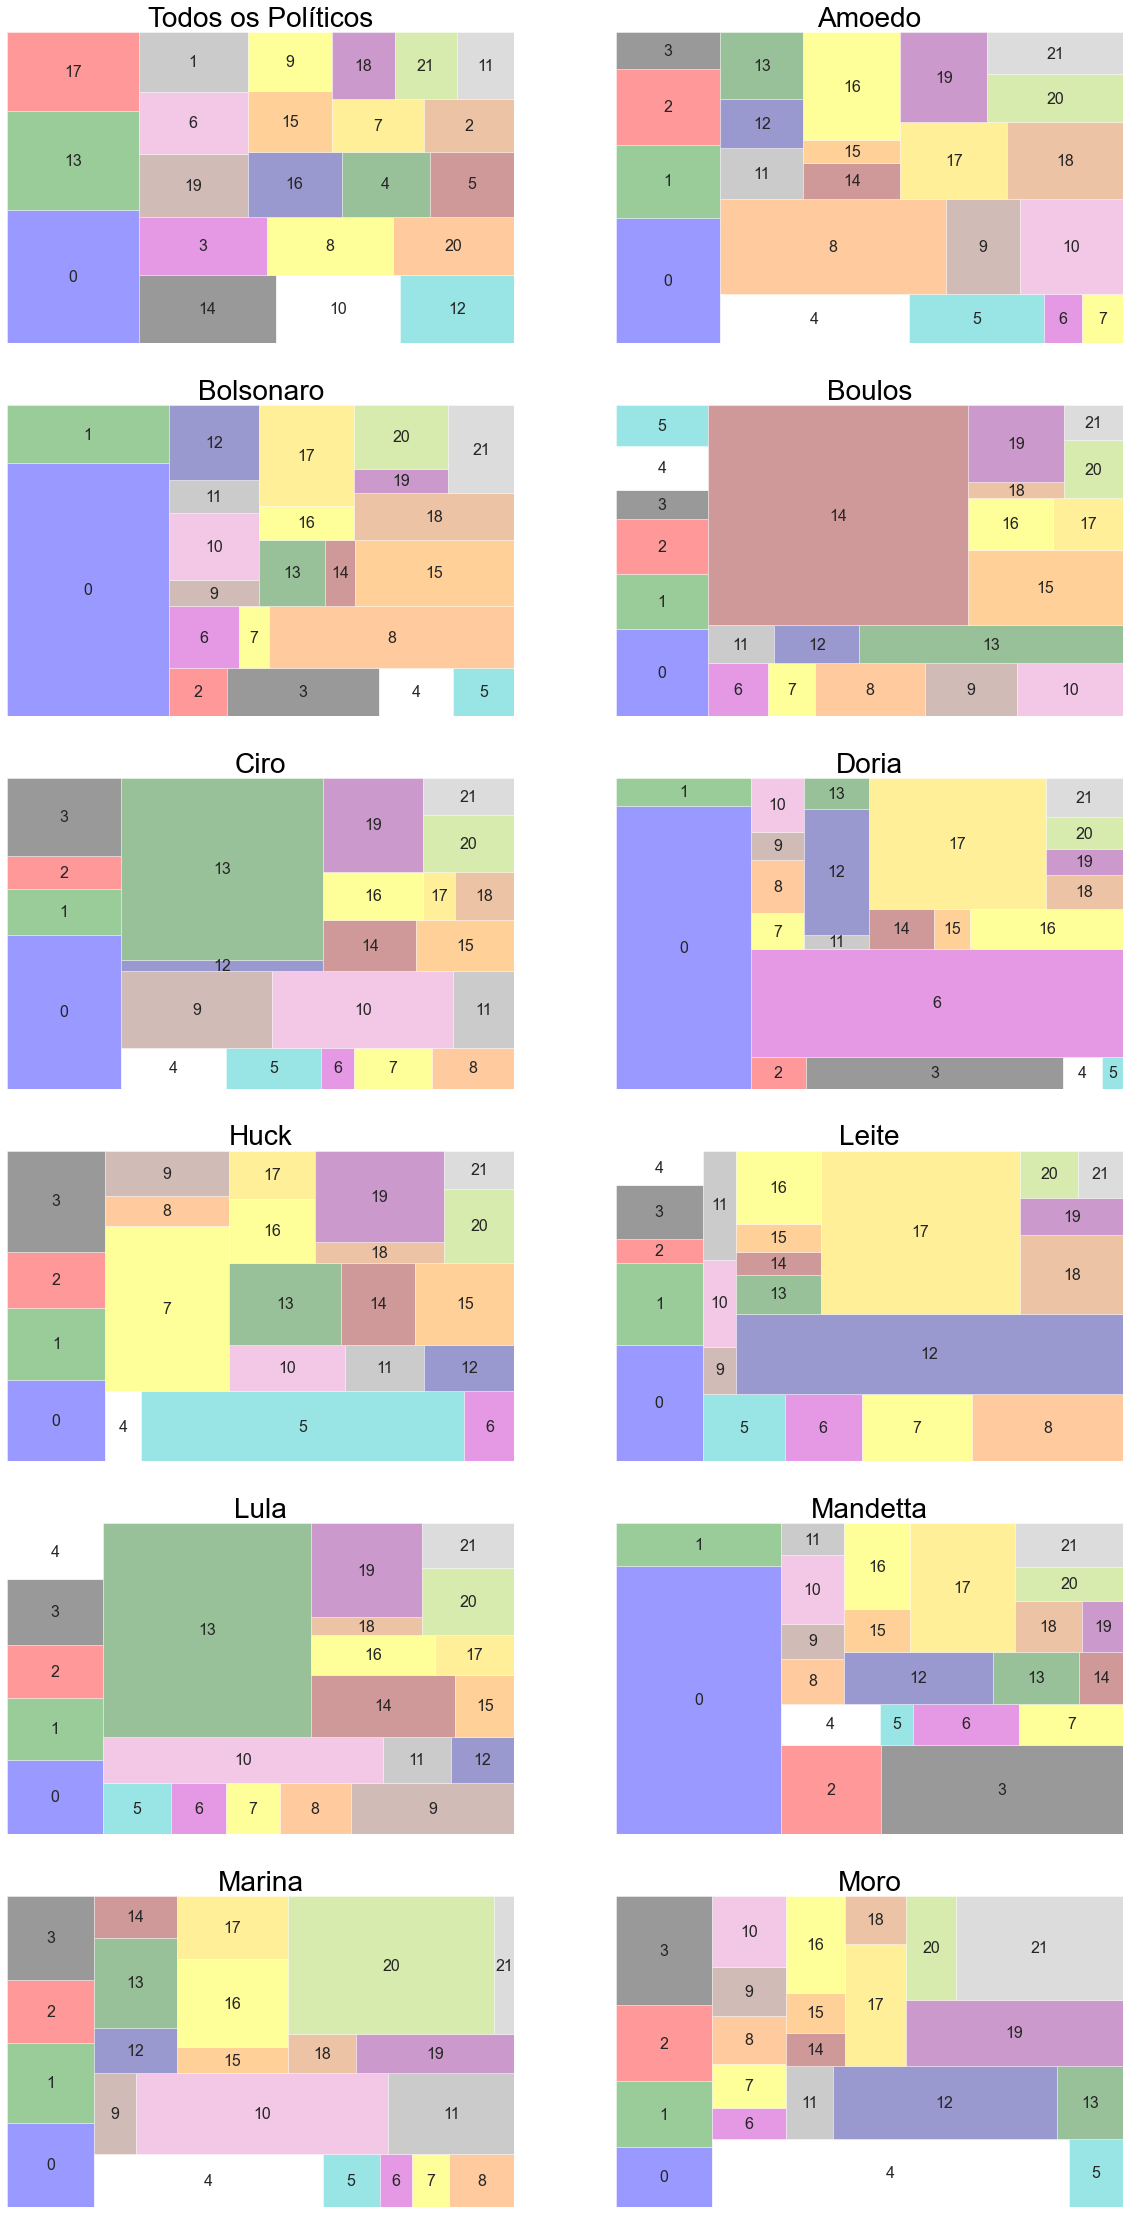

In [41]:
# treemap por politico
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20, 40), facecolor='w')
# Cores para cada tópico
colors = ['b', 'g', 'r', 'k', 'w', 'c', 'm', 'yellow', 'tab:orange', 'tab:brown', 'tab:pink', 'tab:gray', 'darkblue', 'darkgreen', 'darkred', 'darkorange', 'yellow', 'gold', 'chocolate','purple', 'yellowgreen', 'darkgrey']
colors_text = {'r','k','k','k','k','k','k','k','k','k','r','k','k','r','r','k','k','r','k','k','k','k','k'}
xc = 0
yc = 1
# Treemap contagem de tópicos Geral
squarify.plot(sizes=df_topic_distribution['Num Documents'], ax=ax[0][0], label=df_topic_distribution['Topic Num'], alpha=.4, color=colors, text_kwargs={'fontsize': 16})
ax[0][0].set_title('Todos os Políticos', fontsize=28, color='black')
ax[0][0].axis('off')

# Itera a lista de politicos para gerar Treemap de cada politico com seus tópicos
for idx in range(11):
    dfTopicos = df_politicos[df_politicos["nome"]==nome_politicos[idx]].groupby(["Topico"]).size().to_frame().reset_index("Topico")
    dfTopicos.columns = ['Topico', 'Quantidade']
    squarify.plot(sizes=dfTopicos['Quantidade'], ax=ax[xc][yc], label=dfTopicos['Topico'], alpha=.4, color=colors, text_kwargs={'fontsize': 16})
    ax[xc][yc].set_title(nome_politicos[idx], fontsize=28, color='black')
    ax[xc][yc].axis('off')
    yc += 1
    if (yc >= 2):
        yc = 0
        xc += 1
        if (xc >= 6):
            xc = 0   

plt.show()

## Comparar Bolsonaro x Ciro x Doria x Lula

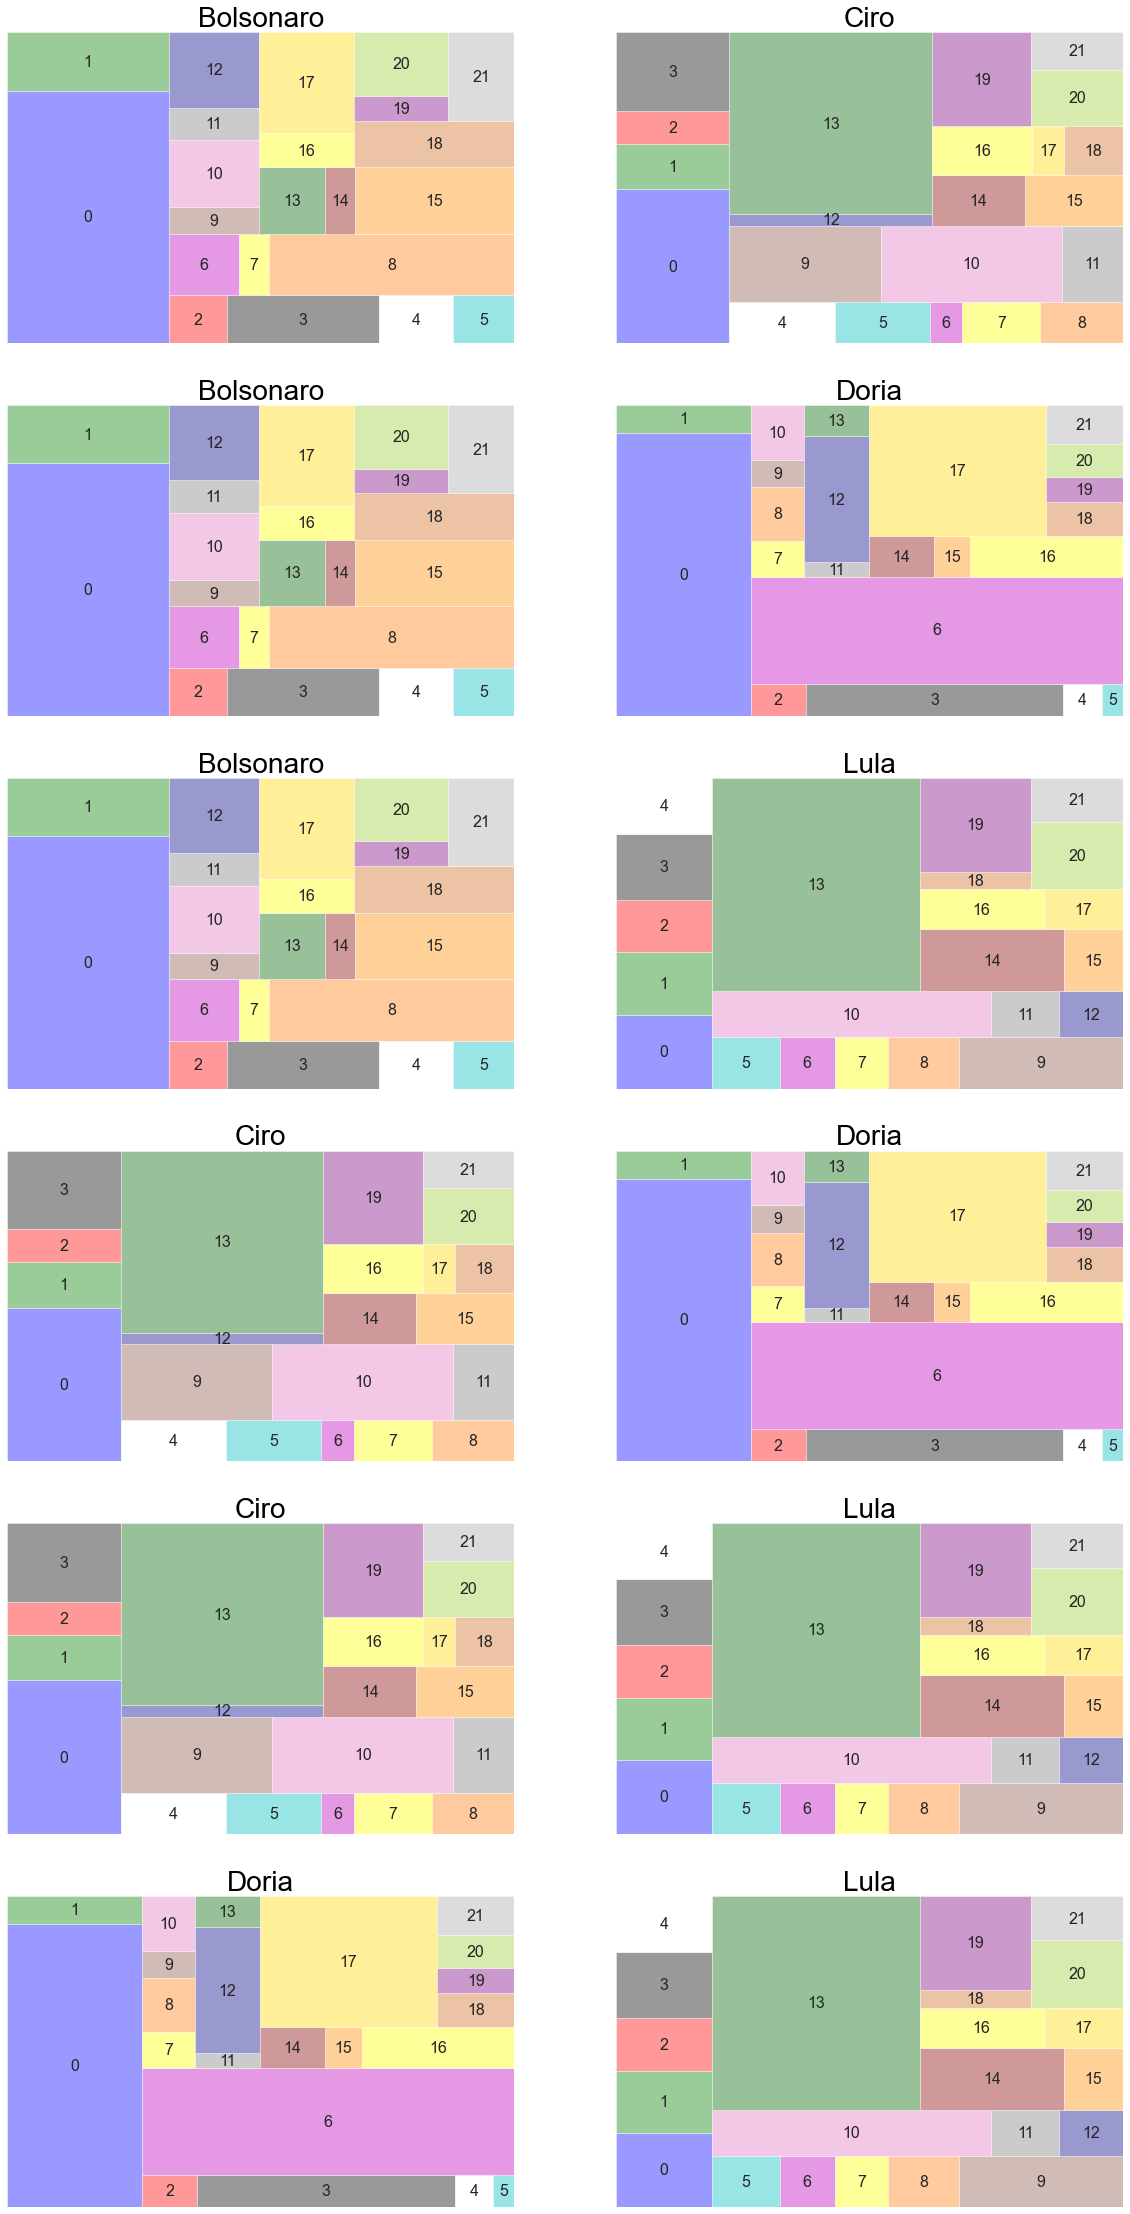

In [42]:
fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(20, 40), facecolor='w')

dfBolsonaro = df_politicos[df_politicos["nome"]=='Bolsonaro'].groupby(["Topico"]).size().to_frame().reset_index("Topico")
dfBolsonaro.columns = ['Topico', 'Quantidade']

dfCiro = df_politicos[df_politicos["nome"]=='Ciro'].groupby(["Topico"]).size().to_frame().reset_index("Topico")
dfCiro.columns = ['Topico', 'Quantidade']

dfDoria = df_politicos[df_politicos["nome"]=='Doria'].groupby(["Topico"]).size().to_frame().reset_index("Topico")
dfDoria.columns = ['Topico', 'Quantidade']

dfLula = df_politicos[df_politicos["nome"]=='Lula'].groupby(["Topico"]).size().to_frame().reset_index("Topico")
dfLula.columns = ['Topico', 'Quantidade']

squarify.plot(sizes=dfBolsonaro['Quantidade'], label=dfBolsonaro['Topico'], color=colors, alpha=.4, ax=ax[0][0], text_kwargs={'fontsize': 16})
ax[0][0].set_title('Bolsonaro', fontsize=28, color='black')
ax[0][0].axis('off')

squarify.plot(sizes=dfCiro['Quantidade'], label=dfCiro['Topico'], color=colors, alpha=.4, ax=ax[0][1], text_kwargs={'fontsize': 16})
ax[0][1].set_title('Ciro', fontsize=28, color='black')
ax[0][1].axis('off')

squarify.plot(sizes=dfBolsonaro['Quantidade'], label=dfBolsonaro['Topico'], color=colors, alpha=.4, ax=ax[1][0], text_kwargs={'fontsize': 16})
ax[1][0].set_title('Bolsonaro', fontsize=28, color='black')
ax[1][0].axis('off')

squarify.plot(sizes=dfDoria['Quantidade'], label=dfDoria['Topico'], color=colors, alpha=.4, ax=ax[1][1], text_kwargs={'fontsize': 16})
ax[1][1].set_title('Doria', fontsize=28, color='black')
ax[1][1].axis('off')

squarify.plot(sizes=dfBolsonaro['Quantidade'], label=dfBolsonaro['Topico'], color=colors, alpha=.4, ax=ax[2][0], text_kwargs={'fontsize': 16})
ax[2][0].set_title('Bolsonaro', fontsize=28, color='black')
ax[2][0].axis('off')

squarify.plot(sizes=dfLula['Quantidade'], label=dfLula['Topico'], color=colors, alpha=.4, ax=ax[2][1], text_kwargs={'fontsize': 16})
ax[2][1].set_title('Lula', fontsize=28, color='black')
ax[2][1].axis('off')

squarify.plot(sizes=dfCiro['Quantidade'], label=dfCiro['Topico'], color=colors, alpha=.4, ax=ax[3][0], text_kwargs={'fontsize': 16})
ax[3][0].set_title('Ciro', fontsize=28, color='black')
ax[3][0].axis('off')

squarify.plot(sizes=dfDoria['Quantidade'], label=dfDoria['Topico'], color=colors, alpha=.4, ax=ax[3][1], text_kwargs={'fontsize': 16})
ax[3][1].set_title('Doria', fontsize=28, color='black')
ax[3][1].axis('off')

squarify.plot(sizes=dfCiro['Quantidade'], label=dfCiro['Topico'], color=colors, alpha=.4, ax=ax[4][0], text_kwargs={'fontsize': 16})
ax[4][0].set_title('Ciro', fontsize=28, color='black')
ax[4][0].axis('off')

squarify.plot(sizes=dfLula['Quantidade'], label=dfLula['Topico'], color=colors, alpha=.4, ax=ax[4][1], text_kwargs={'fontsize': 16})
ax[4][1].set_title('Lula', fontsize=28, color='black')
ax[4][1].axis('off')

squarify.plot(sizes=dfDoria['Quantidade'], label=dfDoria['Topico'], color=colors, alpha=.4, ax=ax[5][0], text_kwargs={'fontsize': 16})
ax[5][0].set_title('Doria', fontsize=28, color='black')
ax[5][0].axis('off')

squarify.plot(sizes=dfLula['Quantidade'], label=dfLula['Topico'], color=colors, alpha=.4, ax=ax[5][1], text_kwargs={'fontsize': 16})
ax[5][1].set_title('Lula', fontsize=28, color='black')
ax[5][1].axis('off')

plt.show()

## Representação Gráfica dos Tópicos

In [43]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
dash = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds = 'pcoa')
dash

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17    -0.192204 -0.015079       1        1  7.580789
0     -0.183758 -0.065995       2        1  7.487790
8     -0.117107  0.007761       3        1  6.005502
13     0.204115 -0.142569       4        1  5.941961
12    -0.102096 -0.009251       5        1  5.793474
10     0.089444  0.140234       6        1  5.711998
14     0.127008 -0.113251       7        1  5.390366
20    -0.016306  0.127393       8        1  5.271751
16    -0.089999  0.047587       9        1  4.656002
3     -0.007199 -0.016583      10        1  4.619333
1     -0.101469  0.027328      11        1  4.590578
4      0.081496  0.132412      12        1  4.282291
19     0.140683  0.077455      13        1  4.200336
6     -0.064778 -0.199390      14        1  3.786570
18    -0.129241  0.000737      15        1  3.523881
2      0.086982  0.090040      16        1  3.311712
5      0.016817  0.017295      17        1  3.219727
21    -0.009704  0.055478      18        1  3.174027
9      0.157565 -0.015203      19        1  3.066367
15     0.051567 -0.150301      20        1  3.057247
11    -0.007676  0.099406      21        1  2.794616
7      0.065859 -0.095504      22        1  2.533682, topic_info=         Term         Freq        Total Category  logprob  loglift
22305    lula   892.000000   892.000000  Default  30.0000  30.0000
31841   saúde  1898.000000  1898.000000  Default  29.0000  29.0000
35397  vacina   818.000000   818.000000  Default  28.0000  28.0000
36392     vou   651.000000   651.000000  Default  27.0000  27.0000
27629     pra  1226.000000  1226.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
31378      rs    45.761446   894.852284  Topic22  -5.4621   0.7023
18579    hoje    49.200653  2086.507650  Topic22  -5.3897  -0.0718
6153   brasil    34.233776  3250.357897  Topic22  -5.7524  -0.8778
24227   mundo    31.036075   786.560683  Topic22  -5.8504   0.4430
31153     rio    30.305570   580.955632  Topic22  -5.8742   0.7222

[1584 rows x 6 columns], token_table=       Topic      Freq   Term
term                         
0          2  0.786392     00
0          4  0.117507     00
0          5  0.027117     00
0          9  0.018078     00
0         11  0.045195     00
...      ...       ...    ...
36903     13  0.357859   ódio
36903     16  0.117118   ódio
36903     20  0.032533   ódio
36904     13  0.777040  ódios
36904     16  0.111006  ódios

[6253 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 1, 9, 14, 13, 11, 15, 21, 17, 4, 2, 5, 20, 7, 19, 3, 6, 22, 10, 16, 12, 8])

# Classificando os Tweets

In [44]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=lda, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

C:\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Word 0       Word 1       Word 2       Word 3      Word 4  \
Topic 0          milhões       vacina        vidas        saúde      brasil   
Topic 1           brasil      auxílio      governo  emergencial        país   
Topic 2        bolsonaro      projeto       câmara        segue  presidente   
Topic 3            saúde          dia        feliz     parabéns    ministro   
Topic 4         ministro       crimes      justiça        crime     decisão   
Topic 5        caldeirão           hj       artigo       brasil          tb   
Topic 6              vou      vacinar     imprensa     coletiva   governosp   
Topic 7   vamosriogrande  borafazerrs          vcs       espero   caldeirão   
Topic 8          bilhões         anos      milhões       brasil    dinheiro   
Topic 9        bolsonaro           pt       brasil          pra     família   
Topic 10       bolsonaro   presidente   democracia       brasil        vida   
Topic 11         governo       brasil     amazônia     ambiente   bolsonaro   
Topic 12       segurança      pública     educação           rs         sul   
Topic 13            lula         hoje         vivo   entrevista          ex   
Topic 14             pra     virasp50        vamos        paulo      boulos   
Topic 15         youtube         link        vamos         2020      juntos   
Topic 16     coronavírus      medidas     pandemia        casos        casa   
Topic 17        pandemia       leitos  coronavírus    população          rs   
Topic 18         reforma   tributária      milhões      governo   hospitais   
Topic 19            news         fake       brasil         país       valeu   
Topic 20         governo       brasil        covid           19    amazônia   
Topic 21         combate      polícia        fundo        crime        lava   

                 Word 5          Word 6        Word 7         Word 8  \
Topic 0         vacinas           covid            19       famílias   
Topic 1         milhões           renda       pessoas       economia   
Topic 2              pt             fio           pra        governo   
Topic 3   profissionais          brasil           rio         frente   
Topic 4       corrupção             stf        brasil            lei   
Topic 5              se           valeu         setor        cidadão   
Topic 6              sp         governo         paulo  transparência   
Topic 7          sábado              hj       carinho           viva   
Topic 8             ano         governo         obras        público   
Topic 9          acesse             pré           pdt           anos   
Topic 10        governo            país   brasileiros       direitos   
Topic 11          ideia        pantanal     queimadas           anos   
Topic 12           hoje  vamosriogrande           lei       estadual   
Topic 13     equipelula      presidente     acompanhe          turma   
Topic 14             sp          cidade         gente       boulos50   
Topic 15             sp            dias           dia       pesquisa   
Topic 16        governo      isolamento        mortes          crise   
Topic 17        governo              sp      trabalho          saúde   
Topic 18       impostos      municípios  respiradores         fiscal   
Topic 19        projeto      presidente         gente        pessoas   
Topic 20      ambiental       indígenas  desmatamento          povos   
Topic 21           jato          drogas      operação       recursos   

                   Word 9          Word 10        Word 11     Word 12  \
Topic 0          butantan      brasileiros         salvar   vacinação   
Topic 1          programa         empresas          fonte      guedes   
Topic 2           pessoas           brasil           voto        país   
Topic 3       aniversário         trabalho       pandemia  ministério   
Topic 4              país          projeto      bolsonaro   congresso   
Topic 5                rs              amp        leitura      adorei   
Topic 6             redes       

In [45]:
# Define function to predict topic for a given text document.
def predict_topic(text):
# Step 1: Clean with simple_preprocess
    text = tweet_tokenizer(text)
# Step 2: Vectorize transform
    vecTweet = tf_vectorizer.transform([text])
# Step 3: LDA Transform
    topic_probability_scores = lda.transform(vecTweet)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 0:14].values.tolist()
# Step 4: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    
    return infer_topic, topic, topic_probability_scores

C:\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
# Predict the topic
print("Tweet Lula")
infer_topic, topic, prob_scores = predict_topic(text = "O fracasso na gestão da pandemia e a volta da fome no Brasil foram retratados em matéria de capa hoje no @nytimes. O desespero de milhões de brasileiros que não tem o que levar à mesa começa a chamar a atenção do mundo. #equipeLula")
print(topic)
print(infer_topic)

Tweet Lula
['lula', 'hoje', 'vivo', 'entrevista', 'ex', 'equipelula', 'presidente', 'acompanhe', 'turma', 'dia', 'brasil', 'assista', 'live', 'vamos']
ricardo
C:\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [47]:
print("Tweet Bolsonaro")
infer_topic, topic, prob_scores = predict_topic(text = "- As águas do São Francisco chegaram ao Ceará. Agora, elas já percorrerem o estado fortalecendo os Rios Jaguaribe e Salgado e abastecendo o reservatório Castanhão.Via @rogeriosmarinho @mdregional_br Segue o fio:")
print(topic)
print(infer_topic)

Tweet Bolsonaro
['lula', 'hoje', 'vivo', 'entrevista', 'ex', 'equipelula', 'presidente', 'acompanhe', 'turma', 'dia', 'brasil', 'assista', 'live', 'vamos']
ricardo
C:\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
print("Tweet Marina")
infer_topic, topic, prob_scores = predict_topic(text = "O dia começou triste com a notícia do falecimento de um grande defensor da natureza, o biólogo Peter Crawshaw. Que Deus console sua família e amigos, e que faça prosperar suas lições e multiplicar, no trabalho de seus alunos e admiradores.")
print(topic)
print(infer_topic)

Tweet Marina
['governo', 'brasil', 'covid', '19', 'amazônia', 'ambiental', 'indígenas', 'desmatamento', 'povos', 'bolsonaro', 'ambiente', 'presidente', 'país', 'política']
pandemia
C:\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
print("Tópico Tweet Huck")
infer_topic, topic, prob_scores = predict_topic(text = "Temos tudo pra ser a maior Potência Verde do Planeta, líderes em descarbonização,  altamente produtivos e sustentáveis ao mesmo tempo. Em importante artigo hoje na @folha, @IlonaSzabo, Robert Muggah, Juan Carlos Castilla-Rubio e Julia Sekula iluminam o caminho. Vale a leitura.")
print(topic)
print(infer_topic)

Tópico Tweet Huck
['caldeirão', 'hj', 'artigo', 'brasil', 'tb', 'se', 'valeu', 'setor', 'cidadão', 'rs', 'amp', 'leitura', 'adorei', 'hoje']
agenda
C:\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [50]:
print("Tópico Tweet Ciro")
infer_topic, topic, prob_scores = predict_topic(text = "Bolsonaro é o covarde que conhecemos bem: mente quando está acuado e depois faz tudo igualzinho pelas costas. Um dia após ter prometido dobrar os investimentos para fiscalização ambiental, seu governo anunciou corte de R$ 240 milhões no orçamento para o Meio Ambiente. Canalhas!")
print(topic)
print(infer_topic)

Tópico Tweet Ciro
['bilhões', 'anos', 'milhões', 'brasil', 'dinheiro', 'ano', 'governo', 'obras', 'público', 'br', 'gastos', '2020', 'km', '2019']
reforma
C:\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
print("Tópico Tweet Doria")
infer_topic, topic, prob_scores = predict_topic(text = "A Polícia Civil de SP receberá nesta semana a primeira viatura blindada da história da instituição. Foram investidos R$ 23 milhões para aquisição de 105 veículos. Outras 70 viaturas blindadas também já foram entregues para reforçar a frota da Polícia Militar.")
print(topic)
print(infer_topic)

Tópico Tweet Doria
['combate', 'polícia', 'fundo', 'crime', 'lava', 'jato', 'drogas', 'operação', 'recursos', 'federal', 'junto', 'organizado', 'pf', 'coronavírus']
tráfico
C:\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
